In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import numpy as np
import pandas as pd 
import cv2
import json
import skimage.io
import tensorflow as tf
import matplotlib.pyplot as plt
import albumentations as albu
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, confusion_matrix
import tensorflow.keras.backend as K
from tensorflow.keras import Model, Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.densenet import DenseNet169, DenseNet121
import efficientnet.tfkeras as efn
print('tensorflow version:', tf.__version__)
print('available GPU devices:', len(os.environ['CUDA_VISIBLE_DEVICES']), 
      '| device num:', os.environ['CUDA_VISIBLE_DEVICES'])
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

tensorflow version: 1.14.0
available GPU devices: 1 | device num: 0
1 Physical GPUs, 1 Logical GPUs


In [2]:
DATA_PATH = './data'
MODELS_PATH = './models'
IMG_SIZE = 96
SEQ_LEN = 8
BATCH_SIZE = 16
MDL_VERSION = 'v0'
SEED = 80

In [3]:
train = pd.read_csv('{}/train.csv'.format(DATA_PATH))
print('train: ', train.shape, '| unique ids:', sum(train['isup_grade'].value_counts()))

train:  (10616, 4) | unique ids: 10616


In [4]:
def get_axis_max_min(array, axis=0):
    one_axis = list((array != 255).sum(axis=tuple([x for x in (0, 1, 2) if x != axis])))
    axis_min = next((i for i, x in enumerate(one_axis) if x), 0)
    axis_max = len(one_axis) - next((i for i, x in enumerate(one_axis[::-1]) if x), 0)
    return axis_min, axis_max

In [5]:
class DataGenPanda(Sequence):
    def __init__(self, imgs_path, df, batch_size=32, 
                 mode='fit', shuffle=False, aug=None, 
                 seq_len=12, img_size=128, n_classes=6):
        self.imgs_path = imgs_path
        self.df = df
        self.shuffle = shuffle
        self.mode = mode
        self.aug = aug
        self.batch_size = batch_size
        self.img_size = img_size
        self.seq_len = seq_len
        self.n_classes = n_classes
        self.side = int(seq_len ** .5)
        self.on_epoch_end()
    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle:
            np.random.shuffle(self.indexes)
    def __getitem__(self, index):
        X = np.zeros((self.batch_size, self.img_size, self.img_size, 3), dtype=np.float64)
        imgs_batch = self.df[index * self.batch_size : (index + 1) * self.batch_size]['image_id'].values
        for i, img_name in enumerate(imgs_batch):
            img_path = '{}/{}.tiff'.format(self.imgs_path, img_name)
            X[i, ] = self.get_patch(img_path)
        if self.mode == 'fit':
            y = np.zeros((self.batch_size, self.n_classes), dtype=np.float32)
            lbls_batch = self.df[index * self.batch_size : (index + 1) * self.batch_size]['isup_grade'].values
            for i in range(self.batch_size):
                y[i, lbls_batch[i]] = 1
            return X, y
        elif self.mode == 'predict':
            return X
        else:
            raise AttributeError('mode parameter error')
    def get_patch(self, img_path):
        num_patches = self.seq_len
        p_size = self.img_size
        img = skimage.io.MultiImage(img_path)[1]
        img = cv2.resize(img, (int(img.shape[1] / 2), int(img.shape[0] / 2)))
        a0min, a0max = get_axis_max_min(img, axis=0)
        a1min, a1max = get_axis_max_min(img, axis=1)
        img = img[a0min:a0max, a1min:a1max, :].astype(np.float32) / 255
        if self.aug:
            img = self.aug(image=img)['image']
        pad0, pad1 = (p_size - img.shape[0] % p_size) % p_size, (p_size - img.shape[1] % p_size) % p_size
        img = np.pad(
            img,
            [
                [pad0 // 2, pad0 - pad0 // 2], 
                [pad1 // 2, pad1 - pad1 // 2], 
                [0, 0]
            ],
            constant_values=1
        )
        img = img.reshape(img.shape[0] // p_size, p_size, img.shape[1] // p_size, p_size, 3)
        img = img.transpose(0, 2, 1, 3, 4).reshape(-1, p_size, p_size, 3)
        if len(img) < num_patches:
            img = np.pad(
                img, 
                [
                    [0, num_patches - len(img)],
                    [0, 0],
                    [0, 0],
                    [0, 0]
                ],
                constant_values=1
            )
        idx = np.random.choice(np.argsort(img.reshape(img.shape[0], -1).sum(-1))[:num_patches])
        return np.array(img[idx])

In [6]:
X_train, X_val = train_test_split(train, test_size=.2, stratify=train['isup_grade'], random_state=SEED)
lbl_value_counts = X_train['isup_grade'].value_counts()
class_weights = {i: max(lbl_value_counts) / v for i, v in lbl_value_counts.items()}
class_weights

{0: 1.0,
 1: 1.0843881856540085,
 2: 2.153631284916201,
 4: 2.315315315315315,
 3: 2.3269617706237424,
 5: 2.362614913176711}

In [7]:
aug = albu.Compose(
    [
        albu.OneOf([albu.RandomBrightness(limit=.15), albu.RandomContrast(limit=.3), albu.RandomGamma()], p=.25),
        albu.HorizontalFlip(p=.25),
        albu.VerticalFlip(p=.25),
        albu.ShiftScaleRotate(shift_limit=.1, scale_limit=.1, rotate_limit=20, p=.25)
    ]
)
train_datagen = DataGenPanda(
    imgs_path='{}/train_images'.format(DATA_PATH), 
    df=X_train, 
    batch_size=BATCH_SIZE,
    mode='fit', 
    shuffle=True, 
    aug=aug, 
    seq_len=SEQ_LEN, 
    img_size=IMG_SIZE, 
    n_classes=6
)
val_datagen = DataGenPanda(
    imgs_path='{}/train_images'.format(DATA_PATH), 
    df=X_val, 
    batch_size=BATCH_SIZE,
    mode='fit', 
    shuffle=False, 
    aug=None, 
    seq_len=SEQ_LEN, 
    img_size=IMG_SIZE, 
    n_classes=6
)

test X:  (16, 96, 96, 3)
test y:  (16, 6)


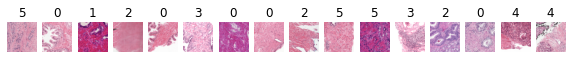

array([[0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.]], dtype=float32)

In [8]:
Xt, yt = train_datagen.__getitem__(0)
print('test X: ', Xt.shape)
print('test y: ', yt.shape)
"""fig, axes = plt.subplots(figsize=(10, 6), nrows=BATCH_SIZE, ncols=SEQ_LEN)
for j in range(BATCH_SIZE):
    for i in range(SEQ_LEN):
        axes[j, i].imshow(Xt[j][i])
        axes[j, i].axis('off')
        axes[j, i].set_title(np.argmax(yt[j, ]))
        #axes[j, i].set_title(yt[j])"""
fig, axes = plt.subplots(figsize=(10, 6), ncols=BATCH_SIZE)
for j in range(BATCH_SIZE):
    axes[j].imshow(Xt[j])
    axes[j].axis('off')
    axes[j].set_title(np.argmax(yt[j, ]))
plt.show()
yt

In [9]:
bottleneck = efn.EfficientNetB3(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet', include_top=False, pooling='avg'
)
bottleneck = Model(inputs=bottleneck.inputs, outputs=bottleneck.layers[-2].output)
model = Sequential()
model.add(bottleneck)
model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dropout(.25))
model.add(Dense(512, activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(.25))
model.add(Dense(6, activation='softmax'))

Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Model)                (None, 3, 3, 1536)        10783528  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
flatten (Flatten)            (None, 1536)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1536)              6144      
_________________________________________________________________
dropout (Dropout)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               786944    
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2

In [11]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(lr=1e-3),
    metrics=['categorical_accuracy']
)

In [ ]:
%%time
model_file = '{}/model_{}.h5'.format(MODELS_PATH, MDL_VERSION)
if False:
    model = load_model(model_file)
    print('model loaded')
else:
    print('train from scratch')
EPOCHS = 1000
earlystopper = EarlyStopping(
    monitor='val_loss', 
    patience=20, 
    verbose=1,
    mode='min'
)
modelsaver = ModelCheckpoint(
    model_file, 
    monitor='val_loss', 
    verbose=1, 
    save_best_only=True,
    mode='min'
)
lrreducer = ReduceLROnPlateau(
    monitor='val_loss',
    factor=.1,
    patience=10,
    verbose=1,
    min_lr=1e-7
)
history = model.fit_generator(
    train_datagen,
    validation_data=val_datagen,
    class_weight=class_weights,
    callbacks=[earlystopper, modelsaver, lrreducer],
    epochs=EPOCHS,
    verbose=1
)

train from scratch
Epoch 1/1000
445/530 [========================>.....] - ETA: 3:47 - loss: 2.6074 - categorical_accuracy: 0.3617

In [ ]:
history_file = '{}/history_{}.txt'.format(MODELS_PATH, MDL_VERSION)
dict_to_save = {}
for k, v in history.history.items():
    dict_to_save.update({k: [np.format_float_positional(x) for x in history.history[k]]})
with open(history_file, 'w') as file:
    json.dump(dict_to_save, file)
ep_max = 100
plt.plot(history.history['loss'][:ep_max], label='loss')
plt.plot(history.history['val_loss'][:ep_max], label='val_loss')
plt.legend()
plt.show()
plt.plot(history.history['categorical_accuracy'][:ep_max], label='cat. accuracy')
plt.plot(history.history['val_categorical_accuracy'][:ep_max], label='val_accuracy')
plt.legend()
plt.show()

In [14]:
%%time
model_file = '{}/model_{}.h5'.format(MODELS_PATH, MDL_VERSION)
model = load_model(model_file)
print('model loaded:', model_file)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


ValueError: Unknown metric function:kappa_score

In [13]:
%%time
X_score = X_val.copy()
val_datagen = DataGenPanda(
    imgs_path='{}/train_images'.format(DATA_PATH), 
    df=X_score, 
    batch_size=1,
    mode='predict', 
    shuffle=False, 
    aug=None, 
    seq_len=SEQ_LEN, 
    img_size=IMG_SIZE, 
    n_classes=6
)
preds = model.predict_generator(val_datagen)

CPU times: user 2min, sys: 15.4 s, total: 2min 15s
Wall time: 1min 37s


In [14]:
y_true = X_score['isup_grade'].values
y_pred = np.argmax(preds, axis=1)
print('quadratic cappa score:', cohen_kappa_score(y_true, y_pred, weights='quadratic'))
print('confusion matrix:\n', confusion_matrix(y_true, y_pred))

quadratic cappa score: 0.7295142353917606
confusion matrix:
 [[480  37   6  13  27  16]
 [122 251 109  23  23   5]
 [ 19  59 128  43  14   6]
 [ 20  13  32 107  36  40]
 [ 16  11  18  40 121  44]
 [ 17   0   8  24  46 150]]
